# Probabilistic CCA on multimodal MNIST

In [1]:
%cd /Users/gwg/local/dmcm
%matplotlib inline

/Users/gwg/local/dmcm


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from   matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.cm as cm

import numpy as np
from   sklearn.decomposition import PCA

from   data   import MnistConfig, MnistDataset
from   models import CCAAE, LeNet5AE
import torch

In [3]:
cfg     = MnistConfig()

k = 2
cfg.PCCA_Z_DIM = k
N = 70000

dataset = MnistDataset(cfg)
ln5     = LeNet5AE(cfg)
model   = CCAAE(cfg)

In [4]:
fname = 'experiments/20181004_mnist_ln5/mnist_mode-ae_latent_dim-8_seed-0_lr-0.001/model.pt'
state = torch.load(fname, map_location={'cuda:0': 'cpu'})
ln5.load_state_dict(state)

In [5]:
def imscatter(points, images, colors, ax, zoom=1, frameon=True):
   
    rgbs = []
    for i, (img, color) in enumerate(zip(images, colors)):
        rgb = np.stack([img, img, img], axis=0)
        if color == 0:
            rgb[0][rgb[0] == 0] = 0
            rgb[1][rgb[1] == 0] = 0
            rgb[2][rgb[2] == 0] = 1
        else:
            rgb[0][rgb[0] == 0] = 1
            rgb[1][rgb[1] == 0] = 0
            rgb[2][rgb[2] == 0] = 0
        rgbs.append(rgb)

    for (x, y), image in zip(points, rgbs):
        try:
            image = np.asarray(Image.fromarray(image.T).convert('RGB'))
        except:
            pass
        im = OffsetImage(image.T, zoom=zoom)
        ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=frameon)
        ax.add_artist(ab)

# ------------------------------------------------------------------------------

def plot(points, colors, images=False):
    fig, ax = plt.subplots(1)
    fig.set_size_inches(20, 20)

    Xp = points[:, 0]
    Yp = points[:, 1]
    
    ax.set_xlim([Xp.min(), Xp.max()])
    ax.set_ylim([Yp.min(), Yp.max()])
    
    if images:
        images = dataset.images[:N].detach().numpy()
        imscatter(points, images, colors, ax)
    else:
        for xp, yp, c in zip(Xp, Yp, colors):
            ax.scatter(xp, yp, c=c, s=2)

# Verify MNIST (single modality) clusters

torch.Size([60000, 8])


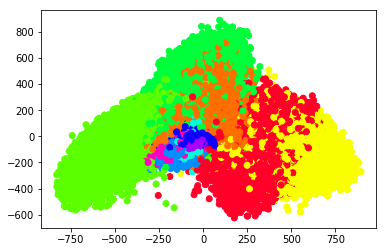

In [6]:
n = 60000
x = dataset.images[:n]
c = dataset.labels[:n]
x = x.unsqueeze(1)
z = ln5.encode(x)
z = z.detach()
print(z.shape)

import seaborn
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
z_ = pca.fit_transform(z)

norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = cm.gist_rainbow_r
m = cm.ScalarMappable(norm=norm, cmap=cmap)

plt.scatter(z_[:, 0], z_[:, 1], c=m.to_rgba(c))
plt.show()

# PCCA

In [7]:
fname = 'mnist_model_I_believe_in.pt'
state = torch.load(fname, map_location={'cuda:0': 'cpu'})
model.load_state_dict(state)

x1 = dataset.images[:N]
x2 = dataset.genes[:N]
labels = dataset.labels[:N]

x1 = x1.unsqueeze(1)

y1 = model.image_net.encode(x1)
y2 = model.genes_net.encode(x2)

y1 = y1 - y1.mean(dim=0)
y2 = y2 - y2.mean(dim=0)
y  = torch.cat([y1, y2], dim=1)
y  = y.t()

z = model.cca.estimate_z_given_y(y)
z = z.t()
z = z.detach().numpy()

In [9]:
z_all = z
z_c   = z[:, :k]
z_a   = z[:, k:2*k]
z_b   = z[:, 2*k:]

norm = mpl.colors.Normalize(vmin=0, vmax=1)
cmap = cm.Set1
print(cmap)
m2 = cm.ScalarMappable(norm=norm, cmap=cmap)

distro_colors = m2.to_rgba(labels >= 5)
class_colors  = m2.to_rgba(c)

# Z_{shared}

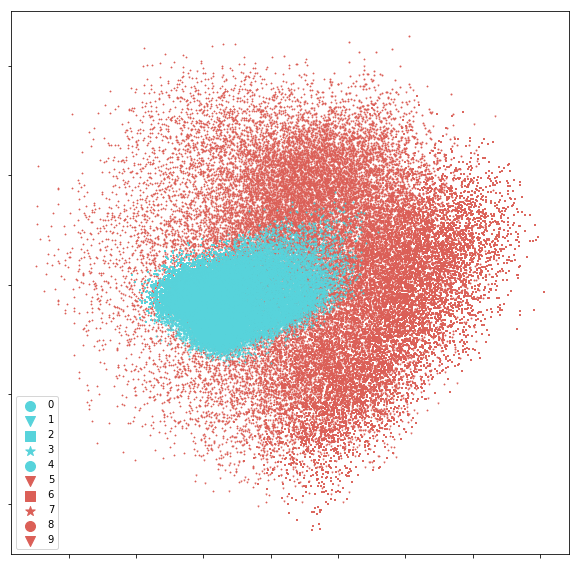

In [34]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)

clrs = seaborn.color_palette('hls', n_colors=2)

LINE_STYLES = ['o', 'v', 's', '*']
NUM_STYLES = len(LINE_STYLES)

Xp = z_c[:, 0]
Yp = z_c[:, 1]
for i in range(10):
    indices = dataset.labels.numpy() == i
    x = Xp[indices]
    y = Yp[indices]
    marker = LINE_STYLES[i % NUM_STYLES]
    c = clrs[0] if i >= 5 else clrs[1]
    zor = 100 if i < 5 else 1
    ax.scatter(x, y, c=c, s=1, label=i, marker=marker, zorder=zor)

ax.set_yticklabels([])
ax.set_xticklabels([])
lgnd = plt.legend(loc="lower left", scatterpoints=1, fontsize=10)
for i in range(10):
    lgnd.legendHandles[i]._sizes = [100]

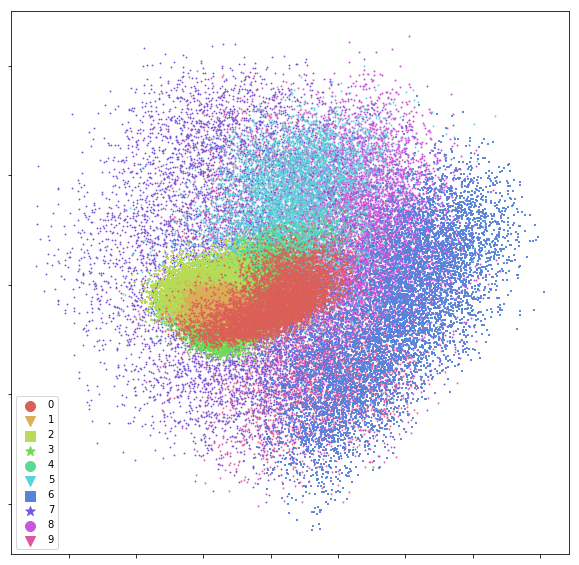

In [36]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)

clrs = seaborn.color_palette('hls', n_colors=10)

LINE_STYLES = ['o', 'v', 's', '*']
NUM_STYLES = len(LINE_STYLES)

Xp = z_c[:, 0]
Yp = z_c[:, 1]
for i in range(10):
    indices = dataset.labels.numpy() == i
    x = Xp[indices]
    y = Yp[indices]
    marker = LINE_STYLES[i % NUM_STYLES]
    ax.scatter(x, y, s=1, c=clrs[i], label=i, marker=marker, zorder=100-i)
   
ax.set_yticklabels([])
ax.set_xticklabels([]) 
lgnd = plt.legend(loc="lower left", scatterpoints=1, fontsize=10)
for i in range(10):
    lgnd.legendHandles[i]._sizes = [100]

# Z_{images}

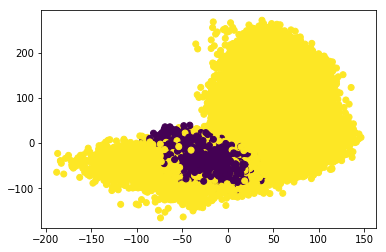

In [11]:
plt.scatter(z_a[:, 0], z_a[:, 1], c=distro_colors)

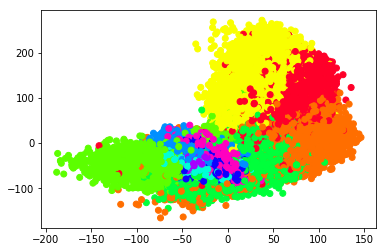

In [12]:
plt.scatter(z_a[:, 0], z_a[:, 1], c=class_colors)

# Z_{genes}

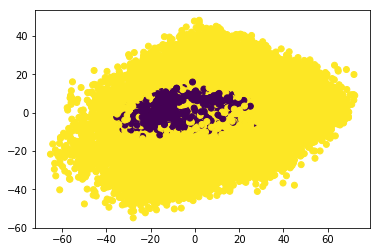

In [13]:
plt.scatter(z_b[:, 0], z_b[:, 1], c=distro_colors)

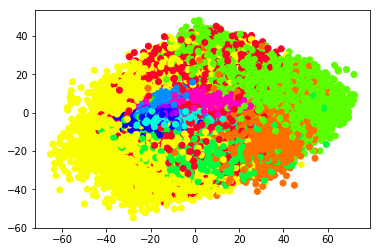

In [14]:
plt.scatter(z_b[:, 0], z_b[:, 1], c=class_colors)